In [165]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from functools import reduce
import joblib


%matplotlib inline
pd.set_option("display.max_columns", None)
%config IPCompleter.greedy = True

In [166]:
route = pd.read_pickle("./route_63__.pkl")
bank_holidays = pd.read_pickle("./bank_holidays__.pkl")
weather = pd.read_pickle("./weather__.pkl")

In [167]:
def route_time_process(df):
    df['hour'] = (df['ActualTime_Arr']//3600) % 24
    return df
route =route_time_process(route)

In [168]:
route[route['hour'] == 23]

,DayOfService,TripID,LineID,RouteID,ProgrNumber,StopPointID,Direction,PlannedTime_Dep,PlannedTime_Arr,ActualTime_Dep,ActualTime_Arr,LastUpdate,hour
390,01-JAN-18 00:00:00,5962513,63,63_25,1,2039,1,86390,84300,84259,84259,08-JAN-18 17:21:10,23
402,01-JAN-18 00:00:00,5962513,63,63_25,2,2040,1,86390,84300,84302,84292,08-JAN-18 17:21:10,23
410,01-JAN-18 00:00:00,5962513,63,63_25,3,2041,1,86390,84300,84407,84376,08-JAN-18 17:21:10,23
423,01-JAN-18 00:00:00,5962513,63,63_25,5,2043,1,86390,84300,84488,84488,08-JAN-18 17:21:10,23
431,01-JAN-18 00:00:00,5962513,63,63_25,6,2044,1,86390,84300,84503,84503,08-JAN-18 17:21:10,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...
587202,06-OCT-18 00:00:00,7782537,63,63_28,30,2030,2,83514,81900,83244,83244,22-OCT-18 22:56:01,23
587215,06-OCT-18 00:00:00,7782538,63,63_25,23,3126,1,86340,84300,85454,85454,22-OCT-18 22:56:01,23
587218,06-OCT-18 00:00:00,7782538,63,63_25,24,3255,1,86340,84300,85495,85495,22-OCT-18 22:56:01,23
587242,06-OCT-18 00:00:00,7782537,63,63_28,20,7634,2,83514,81900,82891,82891,22-OCT-18 22:56:01,23


In [169]:
bank_holidays.head(5)

,date
0,2018-01-01
1,2018-03-19
2,2018-04-02
3,2018-05-07
4,2018-06-04


In [170]:
weather.head(5)

,city_name,lat,lon,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,weather_icon,date,hour
0,Dublin,53.349805,-6.26031,4.15,-6.49,3.84,5.79,990,,,87,12.86,240,40,520,Rain,light intensity shower rain,09n,2018-01-01,0
1,Dublin,53.349805,-6.26031,3.71,-2.28,3.00,5.80,1008,,,75,5.66,240,40,802,Clouds,scattered clouds,03n,2018-01-02,0
2,Dublin,53.349805,-6.26031,5.18,-3.85,5.00,6.66,985,,,87,10.80,260,75,520,Rain,light intensity shower rain,09n,2018-01-03,0
3,Dublin,53.349805,-6.26031,6.06,0.07,5.31,7.29,996,,,87,6.69,230,75,803,Clouds,broken clouds,04n,2018-01-04,0
4,Dublin,53.349805,-6.26031,4.09,-0.08,3.24,5.68,990,,,87,3.60,220,75,803,Clouds,broken clouds,04n,2018-01-05,0


In [171]:
def convert_2_datetime(df, col):
    df[col] = pd.to_datetime(df[col]) 
    return df
route = convert_2_datetime(route, 'DayOfService')
bank_holidays = convert_2_datetime(bank_holidays, 'date')
weather = convert_2_datetime(weather, 'date')

In [172]:
def add_bank_holiday(df, col, bank_holidays, date_col):
    df['bank_holiday'] = np.where(df[col].astype(str).isin(set(list(bank_holidays[date_col].astype(str)))),1,0)
    return df
route = add_bank_holiday(route, 'DayOfService', bank_holidays, 'date')

In [173]:
route[route['bank_holiday'] == 1].tail(10)

,DayOfService,TripID,LineID,RouteID,ProgrNumber,StopPointID,Direction,PlannedTime_Dep,PlannedTime_Arr,ActualTime_Dep,ActualTime_Arr,LastUpdate,hour,bank_holiday
511788,2018-08-06,7327392,63,63_26,42,3282,1,49290,46800,49448,49448,18-AUG-18 18:57:53,13,1
511789,2018-08-06,7327402,63,63_25,42,3283,1,75934,73800,76493,76493,18-AUG-18 18:57:53,21,1
511799,2018-08-06,7327394,63,63_26,2,2040,1,54690,52200,52358,52344,18-AUG-18 18:57:53,14,1
511800,2018-08-06,7327402,63,63_25,2,2040,1,75934,73800,73888,73845,18-AUG-18 18:57:53,20,1
511801,2018-08-06,7315492,63,63_30,4,7324,2,43287,41400,41591,41562,18-AUG-18 18:57:53,11,1
511802,2018-08-06,7315503,63,63_25,4,2042,1,73234,71100,71391,71391,18-AUG-18 18:57:53,19,1
511803,2018-08-06,7315500,63,63_30,7,4396,2,65142,63000,63704,63704,18-AUG-18 18:57:53,17,1
511804,2018-08-06,7315507,63,63_25,7,2045,1,83825,81900,82267,82267,18-AUG-18 18:57:53,22,1
511805,2018-08-06,7315500,63,63_30,15,4771,2,65142,63000,64242,64242,18-AUG-18 18:57:53,17,1
511806,2018-08-06,7315506,63,63_28,15,3307,2,80797,79200,80172,80172,18-AUG-18 18:57:53,22,1


In [174]:
col = ['ProgrNumber', 'Direction', 'hour',
       'bank_holiday', 'temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all',
       'weather_main', 'day_of_week','day_of_year', 'journey_time']

def merge_and_clean(df1, df2, col):
    combined_df = pd.merge(df1, df2,  how='inner', left_on=['DayOfService', 'hour'], 
                           right_on = ['date', 'hour'],
                           suffixes=('_route','_weather'))
    combined_df['Direction'] = combined_df['Direction'].astype('int')
    combined_df['day_of_week'] = combined_df['DayOfService'].dt.dayofweek
    combined_df['day_of_year'] = combined_df['DayOfService'].dt.dayofyear
    combined_df['journey_time'] = combined_df['ActualTime_Dep'] - combined_df['PlannedTime_Arr']
    combined_df['journey_time'] = combined_df['journey_time'].apply(lambda x: x if x > 0 else 0)
    combined_df = combined_df[col]
    return combined_df
df = merge_and_clean(route, weather, col)

In [175]:
df.head(20)

,ProgrNumber,Direction,hour,bank_holiday,temp,pressure,humidity,wind_speed,clouds_all,weather_main,day_of_week,day_of_year,journey_time
0,22,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1049
1,22,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1009
2,23,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1115
3,23,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1065
4,24,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1150
5,24,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1107
6,25,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1178
7,25,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1170
8,26,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1223
9,26,1,11,1,6.01,994,81,12.35,40,Clouds,0,1,1227


(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

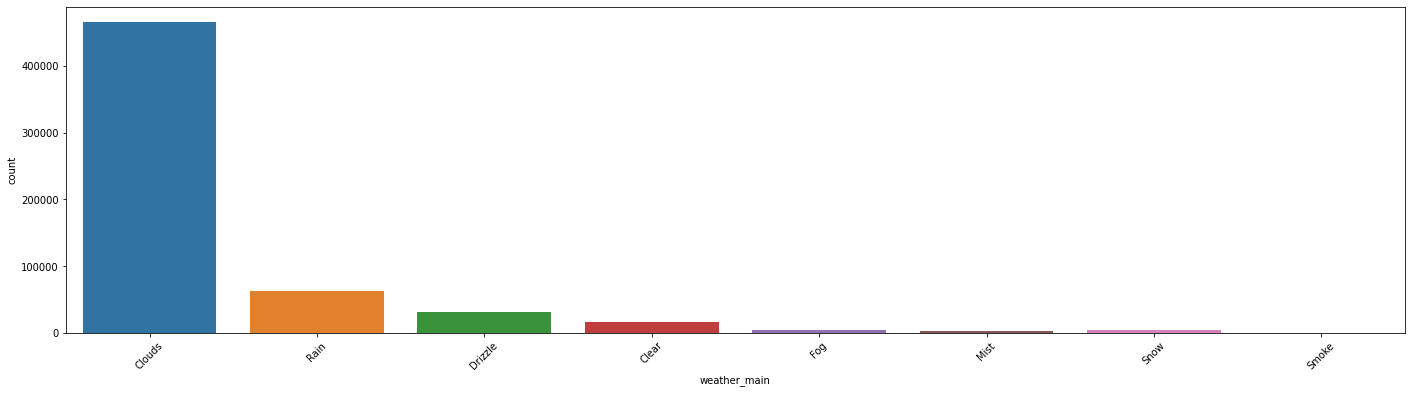

In [176]:
fig, ax = plt.subplots(figsize=(24,6))
ax = sns.countplot(x="weather_main", data=df)
plt.xticks(rotation=45)

In [177]:
def one_hot_encoding(df, col_list):
    df = pd.get_dummies(df, prefix = col_list, columns = col_list)
    return df

In [178]:
def remove_outlier(df):    
    df = df[np.abs(df["journey_time"]-df["journey_time"].mean())<=(3*df["journey_time"].std())]
    return df

In [179]:
df = one_hot_encoding(df, ['weather_main'])
print ("Shape Of The Before Ouliers: ",df.shape)
df = remove_outlier(df)
print ("Shape Of The After Ouliers: ",df.shape)

Shape Of The Before Ouliers:  (587278, 20)
Shape Of The After Ouliers:  (585448, 20)


In [180]:
# fig, axes = plt.subplots(nrows=2,ncols=2, figsize=(20,16))
# sns.boxplot(data=df,y="journey_time",x="bank_holiday",orient="v",ax=axes[0][0])
# sns.boxplot(data=df,y="journey_time",x="day_of_week",orient="v",ax=axes[0][1])
# sns.boxplot(data=df,y="journey_time",x="day_of_year",orient="v",ax=axes[1][0])
# sns.boxplot(data=df,y="journey_time",x="hour",orient="v",ax=axes[1][1])
# axes[0][0].set(ylabel='bank_holiday')
# axes[0][1].set(xlabel='day_of_week', ylabel='journey_time')
# axes[1][0].set(xlabel='day_of_year', ylabel='journey_time')
# axes[1][1].set(xlabel='hour', ylabel='journey_time')

In [181]:
#Slow runnimg

#Finding distribution between different time
# fig, axes = plt.subplots(ncols=2, figsize=(16,6))
# sns.barplot(data=df, y = 'journey_time', x = 'hour', ax=axes[0])
# sns.barplot(data=df, y = 'journey_time', x = 'day_of_week', ax=axes[1])

In [182]:
#Finding correlation of continuous features
# col = ['hour', 'bank_holiday',
#        'temp', 'pressure', 'humidity', 'wind_speed', 'clouds_all',
#        'day_of_week', 'day_of_year', 'journey_time']
# corrMatt = df[col].corr()
# mask = np.array(corrMatt)
# mask[np.tril_indices_from(mask)] = False
# fig,ax= plt.subplots(figsize=(16,12))
# sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)
# plt.show()

In [183]:
# fig, axes = plt.subplots(nrows=3,ncols=2, figsize=(16,12))
# sns.distplot(df["temp"],ax=axes[0][0])
# sns.distplot(df["pressure"],ax=axes[0][1])
# sns.distplot(df["humidity"],ax=axes[1][0])
# sns.distplot(df["wind_speed"],ax=axes[1][1])
# sns.distplot(df["clouds_all"],ax=axes[2][0])
# sns.distplot(df["journey_time"],ax=axes[2][1])

# axes[0][0].set(xlabel='temp', ylabel='d')
# axes[0][1].set(xlabel='pressure', ylabel='d')
# axes[1][0].set(xlabel='humidity', ylabel='d')
# axes[1][1].set(xlabel='wind_speed', ylabel='d')
# axes[2][0].set(xlabel='clouds_all', ylabel='d')
# axes[2][1].set(xlabel='journey_time', ylabel='d')

In [184]:
def time_transform(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col]/max_val)
    df = df.drop([col], axis = 1)
    return df

In [185]:
df = time_transform(df, 'day_of_week', 7)
df = time_transform(df, 'hour', 24)

In [186]:
y = df['journey_time']
x = df.loc[:, df.columns != 'journey_time']

In [187]:
size = len(x) * 9 //10 
x_train, x_test = x[:size], x[size:]
y_train, y_test = y[:size], y[size:]
print(size)

526903


In [188]:
x_train.dtypes

ProgrNumber               int64
Direction                 int64
bank_holiday              int64
temp                    float64
pressure                  int64
humidity                  int64
wind_speed              float64
clouds_all                int64
day_of_year               int64
weather_main_Clear        uint8
weather_main_Clouds       uint8
weather_main_Drizzle      uint8
weather_main_Fog          uint8
weather_main_Mist         uint8
weather_main_Rain         uint8
weather_main_Smoke        uint8
weather_main_Snow         uint8
day_of_week_sin         float64
day_of_week_cos         float64
hour_sin                float64
hour_cos                float64
dtype: object

In [189]:
%%time
#Model validation
lgb_turned = lgb.LGBMRegressor()
lgb_turned.fit(x_train, y_train)
scores=cross_val_score(lgb_turned, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
print("- RMSE: {:.5f}".format(np.mean(scores)))

- RMSE: -270.05260
CPU times: user 1min 5s, sys: 1.68 s, total: 1min 6s
Wall time: 9.53 s


In [190]:
model_name = 'lgbm_model.pkl'
joblib.dump(lgb_turned, model_name)

['lgbm_model.pkl']

In [191]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 697 ms, sys: 22.1 ms, total: 719 ms
Wall time: 110 ms


In [192]:
y_test = y_test.reset_index()["journey_time"]
metrics.mean_squared_error(y_test, y_prediction, squared=False)

318.6690033253472

In [193]:
_prediction = pd.Series(y_prediction)

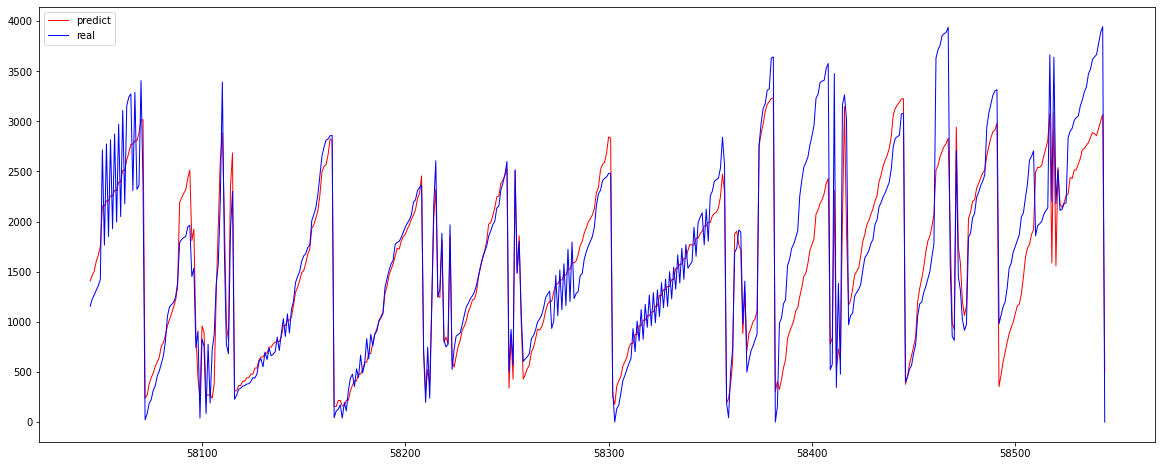

In [194]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(_prediction[-500:], linewidth=1, color = 'red', label = 'predict')
plt.plot(y_test[-500:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()

In [164]:
from sklearn.neighbors import NearestCentroid

In [89]:
x_valued = x #returns a numpy array
scaler = preprocessing.StandardScaler()
x_scaled = scaler.fit_transform(x_valued)

In [96]:
size = len(x) * 9 //10 
x_train_scaled, x_test_scaled = x_scaled[:size], x_scaled[size:]
y_train, y_test = y[:size], y[size:]
print(size)

2409579


In [128]:
%%time

#Model validation
nn = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 16) ,random_state=42, max_iter=100, batch_size=640, verbose=True)
nn.fit(x_train, y_train)
# scores=cross_val_score(bayes, x_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# print("- RMSE: {:.5f}".format(np.mean(scores)))

Iteration 1, loss = 221634.99972192
Iteration 2, loss = 68166.89774555
Iteration 3, loss = 60414.00303191
Iteration 4, loss = 58341.07678488
Iteration 5, loss = 57206.71939136
Iteration 6, loss = 56573.50002446
Iteration 7, loss = 56043.96778936
Iteration 8, loss = 55556.75184235
Iteration 9, loss = 55143.35278704
Iteration 10, loss = 54709.15388789
Iteration 11, loss = 54400.51079347
Iteration 12, loss = 54126.65604485
Iteration 13, loss = 53745.43289524
Iteration 14, loss = 53460.26053022
Iteration 15, loss = 53164.38899749
Iteration 16, loss = 52897.29024736
Iteration 17, loss = 52651.29249958
Iteration 18, loss = 52453.32041934
Iteration 19, loss = 52303.63018500
Iteration 20, loss = 52140.85346939
Iteration 21, loss = 52043.67412868
Iteration 22, loss = 51900.83514417
Iteration 23, loss = 51780.19022839
Iteration 24, loss = 51669.75531198
Iteration 25, loss = 51557.28583754
Iteration 26, loss = 51476.82705075
Iteration 27, loss = 51401.87162891
Iteration 28, loss = 51283.19244315


MLPRegressor(batch_size=640, hidden_layer_sizes=(128, 64, 32, 16), max_iter=100,
             random_state=42, verbose=True)

In [129]:
model_name = 'nn_model.pkl'
joblib.dump(nn, model_name)

['nn_model.pkl']

In [130]:
%%time
model = joblib.load(model_name)
y_prediction = model.predict(x_test)

CPU times: user 4.23 s, sys: 1.03 s, total: 5.27 s
Wall time: 1.35 s


In [131]:
y_test = y_test.reset_index()["journey_time"]
metrics.mean_squared_error(y_test, y_prediction, squared=False)

518.9076994589993

In [132]:
_prediction = pd.Series(y_prediction)

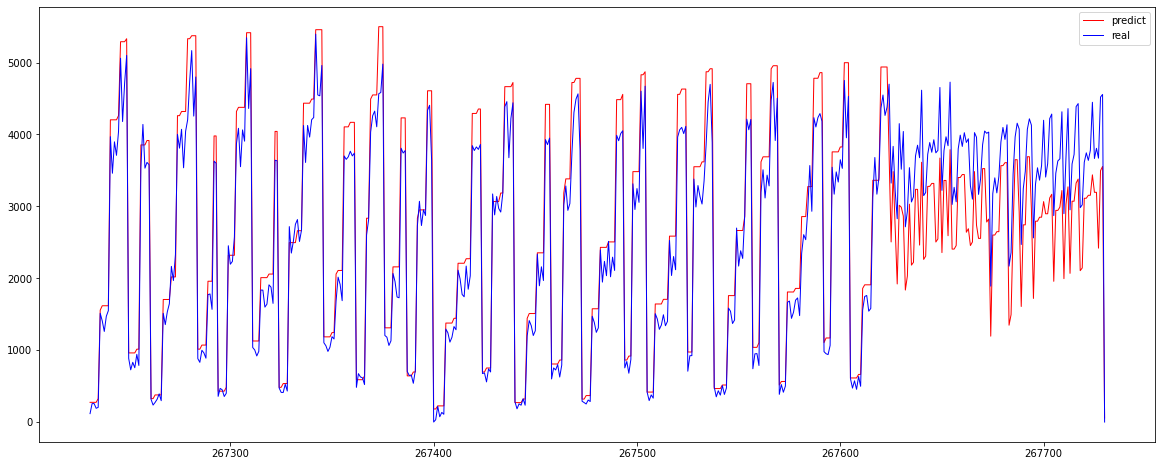

In [133]:
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(_prediction[-500:], linewidth=1, color = 'red', label = 'predict')
plt.plot(y_test[-500:], linewidth=1, color = 'blue', label = 'real')
plt.legend()
plt.show()